In [22]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import tinyarray

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

I_4=tinyarray.array(np.kron(sigma_0, sigma_0))
gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))   
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))  
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B=-300
g=300
las=1
width=30
c=1.0


In [23]:
def make_syst(m,width=50,length=100):
    
    #EG能
    EG_onsite    = (4*c)/las**2 * I_4
    EG_hopping_x = -c/(las**2)*I_4
    EG_hopping_y = -c/(las**2)*I_4 
    
    #TI能
    onsite    = m / 2 * gamma_1 - (4 * B) / (las ** 2) * gamma_2
    hopping_x = B / (las ** 2) * gamma_2 + 1j * g / (2 * las) * gamma_3
    hopping_y = B / (las ** 2) * gamma_2 - 1j * g / (2 * las) * gamma_4


    #scattering能量模型
    def model():
        structure=kwant.lattice.square(las,norbs=4)
        model_sym= kwant.TranslationalSymmetry(structure.vec((-1,0)),structure.vec((0,-1)))
        model_1= kwant.Builder(model_sym)

        model_1[structure(0, 0)] = EG_onsite
        model_1[kwant.builder.HoppingKind((1,0), structure)]  =EG_hopping_x 
        model_1[kwant.builder.HoppingKind((0,1), structure)]  =EG_hopping_y

        return model_1
    
    #lead能量模型
    def model_lead():
        structure=kwant.lattice.square(las,norbs=4)
        model_sym= kwant.TranslationalSymmetry(structure.vec((-1,0)),structure.vec((0,-1)))
        model_1= kwant.Builder(model_sym)

        model_1[structure(0, 0)] = onsite
        model_1[kwant.builder.HoppingKind((1,0), structure)]  = hopping_x
        model_1[kwant.builder.HoppingKind((0,1), structure)]  = hopping_y

        return model_1

    ##create the scattering center

    def shape_center(site):
        x, y = site.pos
        return ((0 < x <= length) and (y==1 or y==width)) or ((x==1 or x==length) and (0 < y <= width))
    syst= kwant.Builder()
    syst.fill(model(), shape_center,(1,1))

    ##create the leads
    width_lead = length//5 

    lead0= kwant.Builder(kwant.TranslationalSymmetry((-1,0)))
    lead1= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    lead2= kwant.Builder(kwant.TranslationalSymmetry((0,1)))

    def shape_lead0(site):
        x, y = site.pos
        return 0 < y <= width

    def shape_lead1(site):
        x, y = site.pos
        return width_lead < x <= 2*width_lead

    def shape_lead2(site):
        x, y = site.pos
        return 3*width_lead < x <= 4*width_lead

    lead0.fill(model_lead(), shape_lead0, (0, 1))
    lead1.fill(model_lead(), shape_lead1, (width_lead+1, 0))
    lead2.fill(model_lead(), shape_lead2, (3*width_lead+1, 0))

    ########### create the six-terminal device
    for lead in [lead0,lead1,lead2, lead0.reversed(),lead2.reversed(),lead1.reversed()]:
        syst.attach_lead(lead)

    return syst.finalized()  


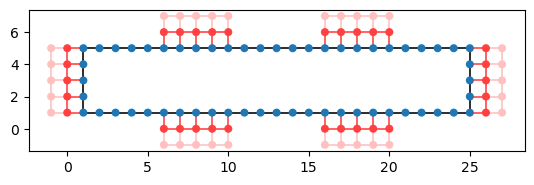

In [24]:
syst1=make_syst(50, 5,25)  
kwant.plot(syst1) ;

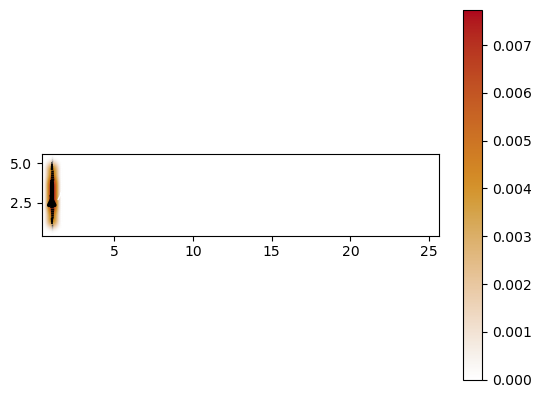

In [25]:
fsyst = make_syst(50,5,25)

J=kwant.operator.Current(fsyst)
wf=kwant.wave_function(fsyst, energy=125)
psi=wf(0)[0]
current = J(psi)
kwant.plotter.current(fsyst, current, colorbar=True, show=True)


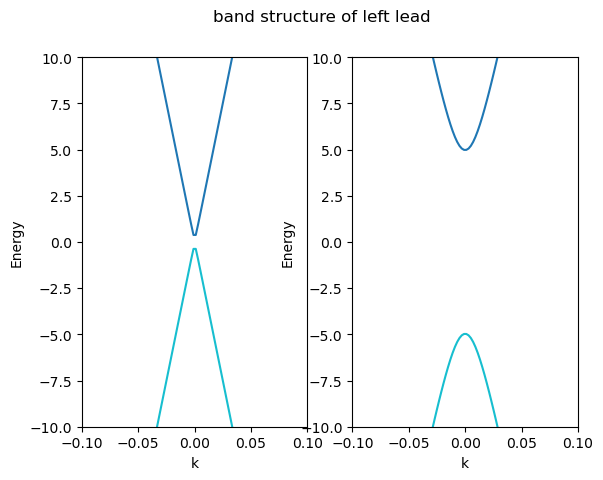

In [26]:
# 能带结构
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('band structure of left lead')
a_x=0.1
a_y=10
for ax in (ax1,ax2):
    ax.set_xlabel('k')
    ax.set_ylabel('Energy')
    ax.set_ylim(-a_y,a_y)
    ax.set_xlim(-a_x,a_x)

syst2=make_syst(50,60,300).leads[0] #提取系统的第一个引线
syst3=make_syst(10,60,300).leads[0]

kwant.plotter.bands(syst2,momenta=np.linspace(-a_x, a_x, 100), ax=ax1);
kwant.plotter.bands(syst3,momenta=np.linspace(-a_x, a_x, 100), ax=ax2);

In [27]:
def find_voltages(tmatrix,current):  #注意：该函数返回的V是所有V的矩阵        #tmatrix是传输矩阵，在此处还未定义，current是电流分布[1, 0, 0, -1, 0, 0] 表示电流从端口1流入，端口4流出。
    try:                                                            #np.linalg.solve()函数用于求解线性方程组，返回值是一个数组，数组中的每个元素是一个未知数的解   
        voltage = np.linalg.solve(tmatrix[1:, 1:], current[1:])     #tmatrix[1:, 1:]表示tmatrix的第一行和第一列被删去 current[1:]表示current的第一个元素被删去  
    except np.linalg.LinAlgError as err:                            #当检测到奇异矩阵时，即该函数无解，避免程序崩溃，强制返回零电压
        if 'Singular matrix' in str(err):
            print("Hi there, singular matrix here")
            voltage = [0,0,0,0,0]
        else:
            raise
    return [0, *voltage]    ##在电压列表前添加一个 0，表示第一个端口的电压为0（参考接地）。
  
def resistance_xx(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
  
    def resistance(a, b): 
        return voltage[a-1]-voltage[b-1] ##默认电流为1 ###将端口的序号索引转化为数组索引
  
    return resistance(2,3) ##电流从端口2流入，端口3流出，电压差为V2-V3
  
def resistance_xy(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
  
    def resistance(a, b):
        return voltage[a-1]-voltage[b-1]
  
    return resistance(2,6)  


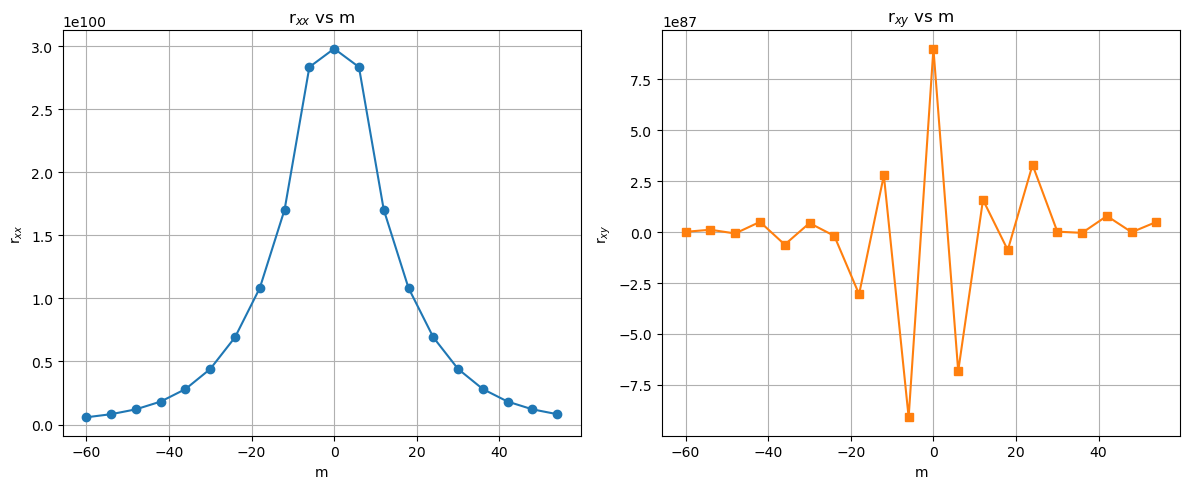

In [28]:
# 计算不同m值下的电阻
m_values = np.arange(-60, 60,6)  
rxx_list = []
rxy_list = []

for m in m_values:
    syst = make_syst(m, width=60, length=300)
    smat = kwant.smatrix(syst, energy=10.0)
    tmat = smat.conductance_matrix()            ######Transmission matrix
    rxx_list.append(resistance_xx(tmat))
    rxy_list.append(resistance_xy(tmat))

#画图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(m_values, rxx_list, 'o-', color='C0')
ax1.set_xlabel('m')
ax1.set_ylabel('r$_{xx}$')
ax1.set_title('r$_{xx}$ vs m')
ax1.grid(True)

ax2.plot(m_values, rxy_list, 's-', color='C1')
ax2.set_xlabel('m')
ax2.set_ylabel('r$_{xy}$')
ax2.set_title('r$_{xy}$ vs m')
ax2.grid(True)

plt.tight_layout()
plt.show()